# Load Data

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("sam-paech/mmlu-pro-nomath-sml")

In [3]:
dataset

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 2639
    })
    validation: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 70
    })
})

In [226]:
df_ground_truth = dataset["test"].to_pandas()

In [227]:
df_ground_truth

,question_id,question,options,answer,answer_index,cot_content,category,src
0,70,"Typical advertising regulatory bodies suggest,...","[Safe practices, Fear, Jealousy, Trivial, Unsa...",I,8,,business,ori_mmlu-business_ethics
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F,5,,business,ori_mmlu-business_ethics
2,72,There are two main issues associated with ____...,"[Down, Autonomy, Remuneration, Benefit, Down, ...",J,9,,business,ori_mmlu-business_ethics
3,73,_______ locate morality beyond the sphere of r...,"[Ethical egoism, Ethics of duty, Postmodern et...",C,2,,business,ori_mmlu-business_ethics
4,74,Some of key differences between Islamic finan...,"[Interest, Certain, Assured, Both tangible and...",G,6,,business,ori_mmlu-business_ethics
...,...,...,...,...,...,...,...,...
2634,12182,Let X be the random variable denoting the resu...,"[f(0) = (0) and f(1) = (1), f(0) = (1/2) and f...",B,1,,engineering,stemez-ElectronicCommunications
2635,12192,The resistance in the circuit of the moving co...,"[Low., Very low., High., Almost zero.]",C,2,,engineering,ori_mmlu-electrical_engineering
2636,12193,A Binary number system has how many digits.,"[0, 1, 2, 10]",C,2,,engineering,ori_mmlu-electrical_engineering
2637,12194,Speed of data transmission in 4-G network of t...,"[10 gbps - 100 gbps., 50 mbps - 500 mbps., 2 m...",D,3,,engineering,ori_mmlu-electrical_engineering


# Experiment: Generate requests and collect responses in parallel

In [77]:
import jsonlines
import os

from llm_council.processors.council_service import (
    get_default_council_service,
    CouncilService,
)

OUTDIR = "data/mmlu_pro.n100.mini.run2"
NUM_EXAMPLES = 100 # Change this to None to use the full set.

CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K", 
    11: "L", 
    12: "M", 
}

def get_options_string(options):
    str = ""
    option_strings = []
    for i, option in enumerate(options):
        option_strings.append(f"{CHOICE_MAP[i]}: {option}")
    return ", ".join(option_strings)
    

def get_answer_string(options, answer_index):
    return CHOICE_MAP[answer_index] + ": " + options[answer_index]
    

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then decide on your final answer. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Provide your final answer, and then provide your reasoning for it. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then finish your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""


PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.

Then, provide your reasoning for your answer.
"""

PROMPT_JUDGE_GROUND_TRUTH_NO_COT = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""


PROMPT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step and then finish your answer with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''


PROMPT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with: "The answer is (X)" where X is the correct letter choice. Then, provide your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step, and then respond with a JSON payload with your reasoning and your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''


STRUCTURED_OUTPUT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice and then your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Begin your response with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_MAP = {
    "so_jgt_cot1": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "so_jgt_cot2": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "so_jgt_cot0": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_jgt_cot1": PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "pr_jgt_cot2": PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "pr_jgt_cot0": PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_ans_cot1": PROMPT_ANSWER_COT_FIRST,
    "pr_ans_cot2": PROMPT_ANSWER_COT_SECOND,
    "pr_ans_cot0": PROMPT_ANSWER_NO_COT,
    "so_ans_cot1": STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    "so_ans_cot2": STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    "so_ans_cot0": STRUCTURED_OUTPUT_ANSWER_NO_COT,
}


def generate_requests(
    prompt_name,
    should_judge_ground_truth,
    temperature,
    schema_name=None,
    role=None,
):
    base_prompt = PROMPT_MAP[prompt_name]
    outdir = os.path.join(
        OUTDIR, 
        ".".join([
            prompt_name,
            # "judge_ground_truth" if should_judge_ground_truth else "answer",
            schema_name if schema_name else "no_schema",
            f"temp{temperature}",
            role if role else "no_role",
    ]))
    
    council_service = CouncilService(
        llm_council_members=[
            "openai://gpt-4o-mini-2024-07-18", 
            # "openai://gpt-4o-2024-08-06",
        ],
        outdir=outdir,
    )

    if NUM_EXAMPLES:
        data = df_ground_truth.head(NUM_EXAMPLES)
    else:
        data = df_ground_truth

    for i, row in data.iterrows():
        realized_prompt = base_prompt.format(
            role=role,
            question=row.question,
            options=get_options_string(row.options),
            answer=get_answer_string(row.options, row.answer_index)
        )
        metadata = {
            "completion_request": {
                "question_id": row["question_id"],
                "temperature": temperature,
                "schema_name": schema_name,
                "should_judge_ground_truth": should_judge_ground_truth,
                "role": role,
            }
        }
        council_service.write_council_request(
            realized_prompt, metadata, temperature, schema_name=schema_name,
        )


# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    temperature=1,
    role="expert",
)

# PROMPT_ANSWER_COT_FIRST
generate_requests(
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    temperature=0,
)

generate_requests(
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    temperature=1,
)

# PROMPT_ANSWER_COT_SECOND
generate_requests(
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    temperature=0,
)

generate_requests(
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    temperature=1,
)

# PROMPT_ANSWER_NO_COT
generate_requests(
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=0,
)

generate_requests(
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_FIRST
generate_requests(
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=0,
)

generate_requests(
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_SECOND
generate_requests(
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=0,
)

generate_requests(
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_NO_COT
generate_requests(
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=0,
)

generate_requests(
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=1,
)

In [ ]:
# Execute requests.
python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run2

170.18 seconds for 10 each.


python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run2

346.10 seconds for 100 each.

# Generate Metrics Dataframe

In [235]:
from datasets import load_dataset
from llm_council.utils import jsonl_io
import jsonlines
import os
import json
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import numpy as np
import pandas as pd
from glob import glob

from llm_council.processors.council_service import (
    CouncilService,
)


# Constants and helper functions remain the same
CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
}

def get_metadata_for_response_file(response_filename):
    # Extract metadata from the response file path
    parts = response_filename.split(os.sep)
    # The structure is: data / mmlu_pro.n100.mini.runX / config / openai / model / responses.jsonl
    run_dir = parts[1]  # e.g., 'mmlu_pro.n100.mini.run0'
    config_dir = parts[2]  # e.g., 'pr_ans_cot1.no_schema.temp1.no_role'
    llm = parts[4]  # e.g., 'gpt-4o-mini-2024-07-18'

    # Extract run number
    run_number = run_dir.split('.')[-1]  # e.g., 'run0'

    # Extract metadata from the configuration directory
    metadata_pieces = config_dir.split('.')
    return {
        "prompt_template": metadata_pieces[0],
        "schema_name": metadata_pieces[1],
        "temperature": metadata_pieces[2],
        "role": metadata_pieces[3],
        "llm": llm,
        "run_number": run_number,
    }

def parse_my_assessment_substring(response_string):
    response_string = response_string.lower()
    if "my assessment is" in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("my assessment is ")[-1][0]
        return assessment.upper()
    if "the answer is " in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("the answer is ")[-1][0]
        return assessment.upper()
    return "ERROR"

# New function to collect configurations and their response files across runs
def collect_configurations(base_dir):
    """
    Collects all configurations and their corresponding response files across runs.

    Parameters:
    - base_dir: The base directory containing all runs.

    Returns:
    - config_response_files: Dictionary mapping configurations to their response files across runs.
    """
    # Use glob to find all response files
    response_files = glob(os.path.join(base_dir, '**', 'responses.jsonl'), recursive=True)

    # Map configurations to their response files
    config_response_files = {}
    for response_file in response_files:
        metadata = get_metadata_for_response_file(response_file)
        # Use a tuple of configuration parameters as the key
        config_key = (
            metadata['prompt_template'],
            metadata['schema_name'],
            metadata['temperature'],
            metadata['role'],
            metadata['llm']
        )
        if config_key not in config_response_files:
            config_response_files[config_key] = []
        config_response_files[config_key].append(response_file)
    return config_response_files

# Function to process a single configuration across runs
def process_configuration(response_files, df_ground_truth, council_service, k=2):
    """
    Processes a single configuration across multiple runs to compute metrics.

    Parameters:
    - response_files: List of response files for this configuration across runs.
    - df_ground_truth: DataFrame containing ground truth answers.
    - k: Exponent for the Exponential Consistency Weighted Metric.

    Returns:
    - metrics: Dictionary of computed metrics for this configuration.
    """
    total_runs = len(response_files)
    per_run_accuracies = []
    per_run_unparsable = []
    per_run_uncertain = []
    per_run_response_lengths = []
    per_run_response_lengths_stdev = []

    item_correct_counts = {}
    item_ids = set()

    df_all_runs = pd.DataFrame()

    for run_idx, response_file in enumerate(response_files):
        metadata = get_metadata_for_response_file(response_file)
        prompt_template = metadata.get('prompt_template', '')
        schema_name = metadata.get('schema_name', '')

        num_items = 0
        num_correct_items = 0
        num_unparsable_items = 0
        num_uncertain_items_for_judging_ground_truth = 0
        response_lengths = []

        item_ids_run = []
        is_correct_list = []

        with jsonlines.open(response_file) as reader:
            for response_data in reader:
                num_items += 1

                response_string = council_service.get_llm_response_string(response_data)
                response_lengths.append(len(response_string))

                question_id = response_data[-1]["completion_request"]["question_id"]
                item_ids_run.append(question_id)
                item_ids.add(question_id)

                df_row = df_ground_truth[df_ground_truth["question_id"] == question_id]

                if schema_name != "no_schema":
                    try:
                        json_payload = json.loads(response_string)
                        parsed_assessment = json_payload.get("answer", "ERROR")
                    except json.JSONDecodeError:
                        parsed_assessment = "ERROR"
                else:
                    parsed_assessment = parse_my_assessment_substring(response_string)

                if parsed_assessment == "ERROR":
                    num_unparsable_items += 1
                    is_correct = False
                else:
                    if "ans" in prompt_template:
                        ground_truth = df_row["answer"].item()
                        is_correct = (parsed_assessment == ground_truth)
                    else:
                        # For prompts without 'ans', consider 'A' as correct
                        is_correct = (parsed_assessment == "A")
                        if parsed_assessment == "C":
                            num_uncertain_items_for_judging_ground_truth += 1

                    if is_correct:
                        num_correct_items += 1

                is_correct_list.append(is_correct)

                # Update per-item correctness counts
                if question_id not in item_correct_counts:
                    item_correct_counts[question_id] = 0
                if is_correct:
                    item_correct_counts[question_id] += 1

        # Compute metrics for this run
        accuracy = num_correct_items / num_items if num_items > 0 else 0
        per_run_accuracies.append(accuracy)

        pct_unparsable_items = num_unparsable_items / num_items if num_items > 0 else 0
        per_run_unparsable.append(pct_unparsable_items)

        pct_uncertain_items = num_uncertain_items_for_judging_ground_truth / num_items if num_items > 0 else 0
        per_run_uncertain.append(pct_uncertain_items)

        response_length_mean = np.mean(response_lengths) if response_lengths else 0
        response_length_stdev = np.std(response_lengths) if response_lengths else 0
        per_run_response_lengths.append(response_length_mean)
        per_run_response_lengths_stdev.append(response_length_stdev)

        # Create DataFrame for this run's per-item correctness
        df_run = pd.DataFrame({
            'question_id': item_ids_run,
            f'is_correct_run{run_idx}': is_correct_list
        })

        if df_all_runs.empty:
            df_all_runs = df_run
        else:
            df_all_runs = df_all_runs.merge(df_run, on='question_id', how='outer')

    # Compute per-item correctness fraction across runs
    correctness_columns = [col for col in df_all_runs.columns if col.startswith('is_correct_run')]
    df_all_runs['correct_count'] = df_all_runs[correctness_columns].sum(axis=1)
    df_all_runs['fraction_correct'] = df_all_runs['correct_count'] / total_runs
    df_all_runs['weighted_score'] = df_all_runs['fraction_correct'] ** k

    # Compute Exponential Consistency Weighted Metric
    ecwm = df_all_runs['weighted_score'].mean()

    # Compute overall metrics
    accuracy_mean = np.mean(per_run_accuracies)
    accuracy_stdev = np.std(per_run_accuracies)
    unparsable_mean = np.mean(per_run_unparsable)
    unparsable_stdev = np.std(per_run_unparsable)
    uncertain_mean = np.mean(per_run_uncertain)
    uncertain_stdev = np.std(per_run_uncertain)
    response_length_mean = np.mean(per_run_response_lengths)
    response_length_stdev = np.std(per_run_response_lengths)
    response_length_stdev_mean = np.mean(per_run_response_lengths_stdev)
    response_length_stdev_stdev = np.std(per_run_response_lengths_stdev)

    # Prepare the metrics dictionary
    metrics = {
        'accuracy_mean': accuracy_mean,
        'accuracy_stdev': accuracy_stdev,
        f'exponential_consistency_weighted_metric_k{k}': ecwm,
        'pct_unparsable_items_mean': unparsable_mean,
        'pct_unparsable_items_stdev': unparsable_stdev,
        'pct_uncertain_items_mean': uncertain_mean,
        'pct_uncertain_items_stdev': uncertain_stdev,
        'response_length_mean': response_length_mean,
        'response_length_stdev': response_length_stdev,
        'response_length_stdev_mean': response_length_stdev_mean,
        'response_length_stdev_stdev': response_length_stdev_stdev,
        'num_items': len(item_ids),
        'num_runs': total_runs,
    }

    # Include configuration metadata
    config_metadata = {
        'prompt_template': metadata['prompt_template'],
        'schema_name': metadata['schema_name'],
        'temperature': metadata['temperature'],
        'role': metadata['role'],
        'llm': metadata['llm'],
        'cot_type': metadata['prompt_template'].split('_')[-1],
    }

    metrics.update(config_metadata)

    return metrics


# Main function to process all configurations
def process_all_configurations(base_dir, df_ground_truth, council_service, k=2):
    """
    Processes all configurations across runs and compiles metrics.

    Parameters:
    - base_dir: Base directory containing all runs.
    - df_ground_truth: DataFrame containing ground truth answers.
    - k: Exponent for the Exponential Consistency Weighted Metric.

    Returns:
    - df_final_metrics: DataFrame containing metrics for all configurations.
    """
    config_response_files = collect_configurations(base_dir)

    all_metrics = []
    for config_key, response_files in config_response_files.items():
        # Process this configuration
        metrics = process_configuration(response_files, df_ground_truth, council_service, k)
        all_metrics.append(metrics)

    # Convert to DataFrame
    df_final_metrics = pd.DataFrame(all_metrics)

    return df_final_metrics

In [236]:
# Get metrics.
# Base directory containing all runs
base_dir = 'data_mmlu'

# Initialize council service with the llms that you want to analyze.
council_service = CouncilService(
    llm_council_members=[
        "openai://gpt-4o-mini-2024-07-18",
    ]
)

# Process all configurations
df_metrics = process_all_configurations(base_dir, df_ground_truth, council_service, k=2)

In [211]:
# Copy to clipboard to paste into sheets for more convenient analysis.
df_metrics.to_clipboard()

# Plotting Accuracy

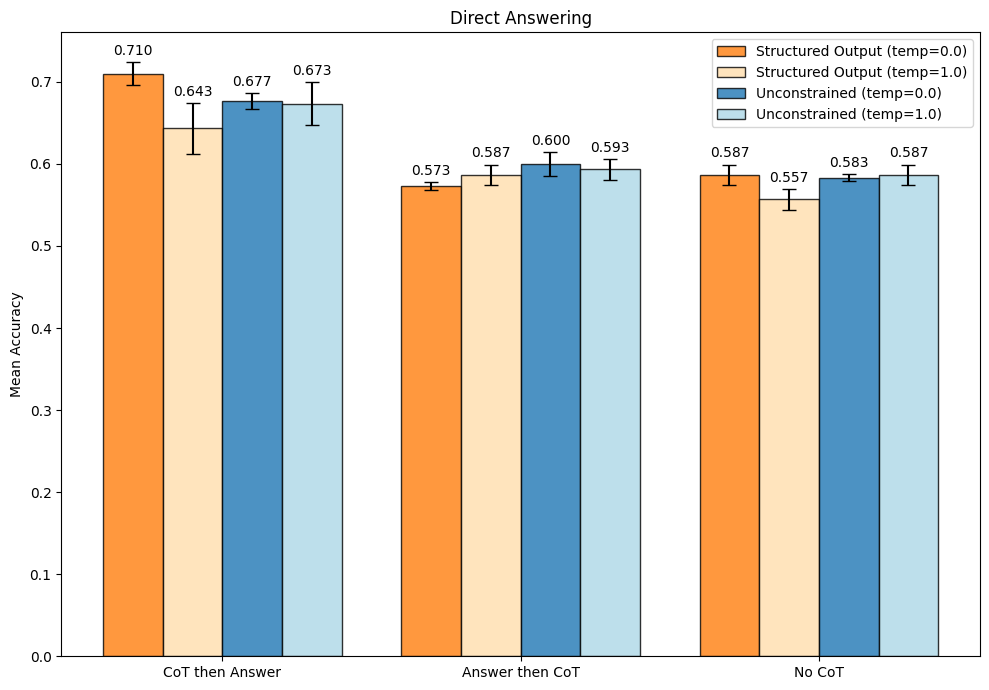

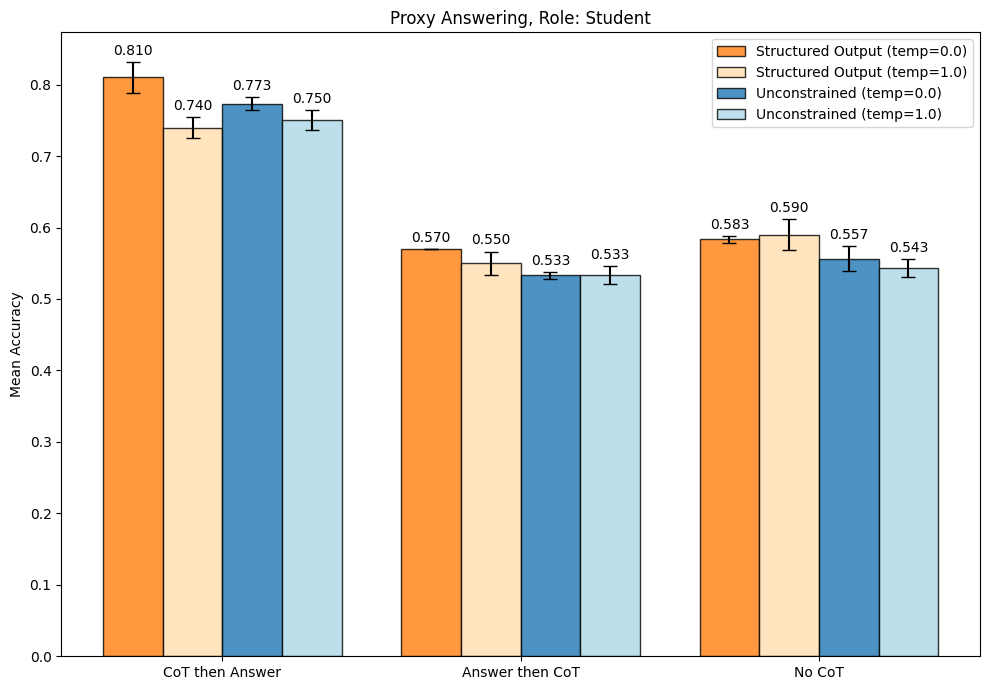

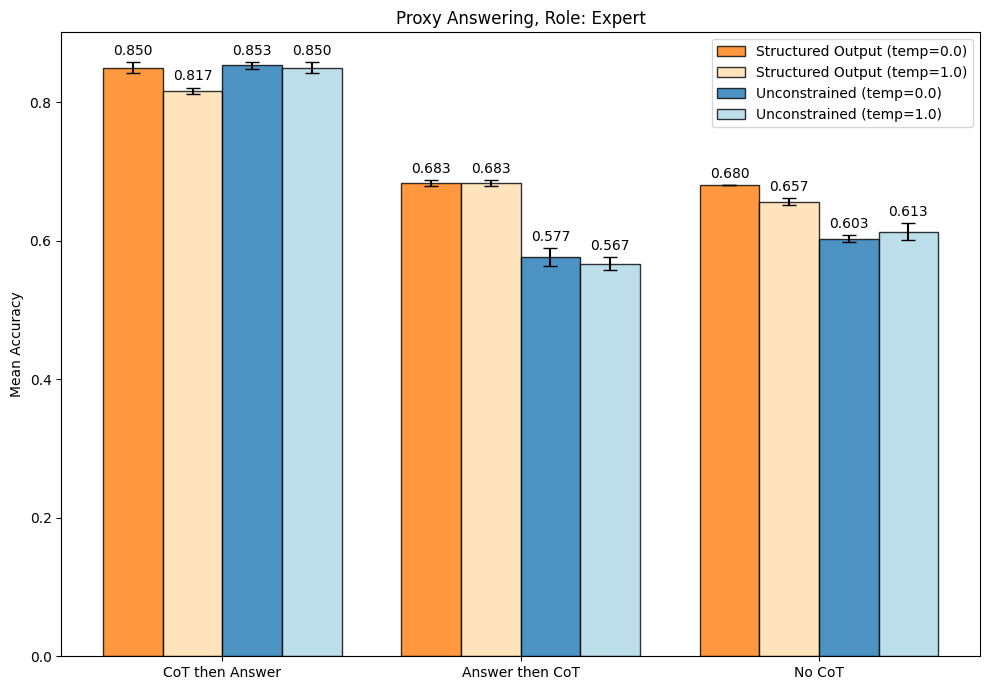

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to classify schema names as "Unconstrained" or "Structured Output"
def classify_schema(schema_name):
    if schema_name.lower() == 'no_schema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph with error bars
def plot_grouped_bars_combined(filtered_df, ans_jgt, role=None):
    # Ensure 'cot_type' ordering.
    cot_order = ['cot1', 'cot2', 'cot0']
    
    # Map 'schema_name' to either "Unconstrained" or "Structured Output"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Map temperature to readable labels
    temp_mapping = {'temp0': 'temp=0.0', 'temp1': 'temp=1.0'}
    filtered_df['temperature_label'] = filtered_df['temperature'].map(temp_mapping)
    
    # Combine 'schema_group' and 'temperature_label' to create 'group' variable
    filtered_df['group'] = filtered_df['schema_group'] + ' (' + filtered_df['temperature_label'] + ')'
    
    # Calculate the error bars using accuracy standard deviation
    filtered_df['yerr'] = filtered_df['accuracy_stdev']
    
    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(
        index='cot_type',
        columns='group',
        values=['accuracy_mean', 'yerr']
    ).reindex(cot_order)
    
    # Get the number of CoT types and groups
    num_cot_types = len(cot_order)
    groups = pivot_df.columns.levels[1]
    num_groups = len(groups)
    
    # Width settings for grouped bars
    total_width = 0.8
    bar_width = total_width / num_groups
    x = np.arange(num_cot_types)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define colors for each group
    colors = {
        'Unconstrained (temp=0.0)': 'tab:blue',
        'Unconstrained (temp=1.0)': 'lightblue',
        'Structured Output (temp=0.0)': 'tab:orange',
        'Structured Output (temp=1.0)': 'navajowhite'  # light orange
    }
    
    for i, group in enumerate(groups):
        means = pivot_df['accuracy_mean'][group].values
        errors = pivot_df['yerr'][group].values
        positions = x + i * bar_width - total_width/2 + bar_width/2
        
        bars = ax.bar(
            positions,
            means,
            yerr=errors,
            width=bar_width,
            label=group,
            capsize=5,
            edgecolor='black',
            color=colors.get(group, 'gray'),
            alpha=0.8
        )
        
        # Add text annotations for each bar
        ax.bar_label(bars, labels=[f'{mean:.3f}' for mean in means], padding=3, fontsize=10)
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels([cot_labels[label] for label in cot_order])
    
    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Mean Accuracy')

    # Get base title
    if ans_jgt == "ans":
        base_title = "Direct Answering"
    else:
        base_title = "Proxy Answering"

    if role:
        ax.set_title(f'{base_title}, Role: {role.capitalize()}')
    else:
        ax.set_title(f'{base_title}')
    
    ax.legend(title='')
    plt.tight_layout()
    plt.show()
    
# Function to extract CoT type from 'prompt_template'
def extract_cot_type(prompt_template):
    return prompt_template.split('_')[-1]

# Plotting for 'ans' (Direct Answering)
filtered_df_ans = df_metrics[
    df_metrics['prompt_template'].str.contains('ans') &
    (df_metrics['role'] == 'no_role')
].copy()

# Add CoT type as a separate column (cot0, cot1, cot2)
filtered_df_ans['cot_type'] = filtered_df_ans['prompt_template'].apply(extract_cot_type)

# Proceed to plot
plot_grouped_bars_combined(filtered_df_ans, ans_jgt='ans')

# Plotting for 'jgt' (Proxy Answering)
for role in ['student', 'expert']:
    filtered_df_jgt = df_metrics[
        df_metrics['prompt_template'].str.contains('jgt') &
        (df_metrics['role'] == role)
    ].copy()
    
    # Add CoT type as a separate column (cot0, cot1, cot2)
    filtered_df_jgt['cot_type'] = filtered_df_jgt['prompt_template'].apply(extract_cot_type)
    
    # Proceed to plot
    plot_grouped_bars_combined(filtered_df_jgt, ans_jgt='jgt', role=role)


# Plotting Exponentially Weighted Consistency Metric (k=2)

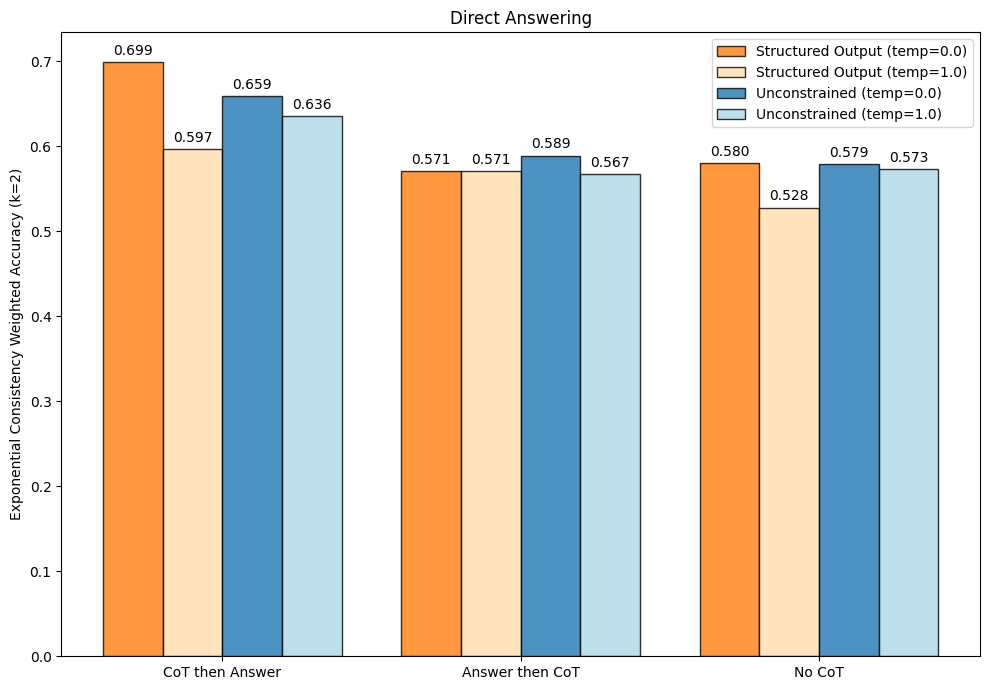

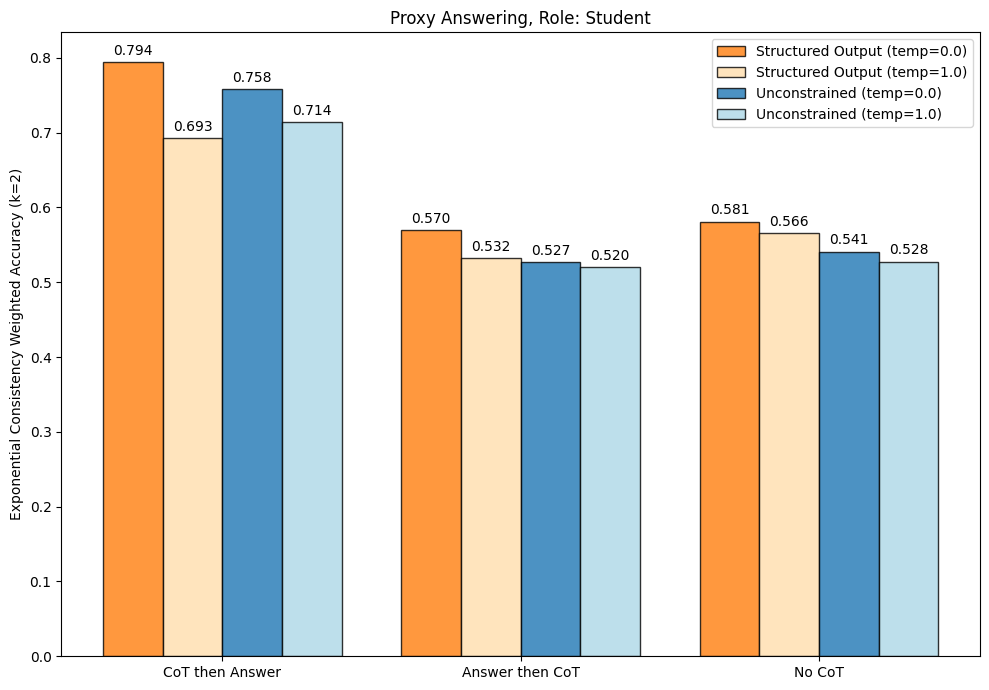

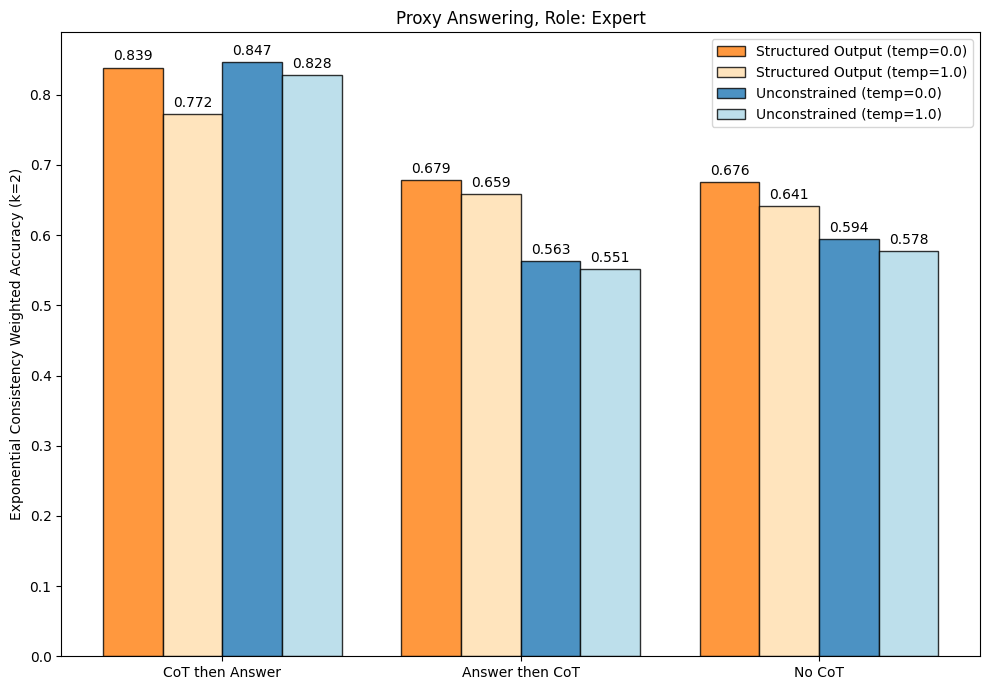

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to classify schema names as "Unconstrained" or "Structured Output"
def classify_schema(schema_name):
    if schema_name.lower() == 'no_schema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph with error bars
def plot_grouped_bars_combined(filtered_df, ans_jgt, role=None):
    # Ensure 'cot_type' ordering.
    cot_order = ['cot1', 'cot2', 'cot0']
    
    # Map 'schema_name' to either "Unconstrained" or "Structured Output"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Map temperature to readable labels
    temp_mapping = {'temp0': 'temp=0.0', 'temp1': 'temp=1.0'}
    filtered_df['temperature_label'] = filtered_df['temperature'].map(temp_mapping)
    
    # Combine 'schema_group' and 'temperature_label' to create 'group' variable
    filtered_df['group'] = filtered_df['schema_group'] + ' (' + filtered_df['temperature_label'] + ')'
    
    # Calculate the error bars using accuracy standard deviation
    # filtered_df['yerr'] = filtered_df['accuracy_stdev']
    
    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(
        index='cot_type',
        columns='group',
        values=['exponential_consistency_weighted_metric_k2']
    ).reindex(cot_order)
    
    # Get the number of CoT types and groups
    num_cot_types = len(cot_order)
    groups = pivot_df.columns.levels[1]
    num_groups = len(groups)
    
    # Width settings for grouped bars
    total_width = 0.8
    bar_width = total_width / num_groups
    x = np.arange(num_cot_types)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define colors for each group
    colors = {
        'Unconstrained (temp=0.0)': 'tab:blue',
        'Unconstrained (temp=1.0)': 'lightblue',
        'Structured Output (temp=0.0)': 'tab:orange',
        'Structured Output (temp=1.0)': 'navajowhite'  # light orange
    }
    
    for i, group in enumerate(groups):
        means = pivot_df['exponential_consistency_weighted_metric_k2'][group].values
        # errors = pivot_df['yerr'][group].values
        positions = x + i * bar_width - total_width/2 + bar_width/2
        
        bars = ax.bar(
            positions,
            means,
            # yerr=errors,
            width=bar_width,
            label=group,
            capsize=5,
            edgecolor='black',
            color=colors.get(group, 'gray'),
            alpha=0.8
        )
        
        # Add text annotations for each bar
        ax.bar_label(bars, labels=[f'{mean:.3f}' for mean in means], padding=3, fontsize=10)
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels([cot_labels[label] for label in cot_order])
    
    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Exponential Consistency Weighted Accuracy (k=2)')

    # Get base title
    if ans_jgt == "ans":
        base_title = "Direct Answering"
    else:
        base_title = "Proxy Answering"

    if role:
        ax.set_title(f'{base_title}, Role: {role.capitalize()}')
    else:
        ax.set_title(f'{base_title}')
    
    ax.legend(title='')
    plt.tight_layout()
    plt.show()
    
# Function to extract CoT type from 'prompt_template'
def extract_cot_type(prompt_template):
    return prompt_template.split('_')[-1]

# Plotting for 'ans' (Direct Answering)
filtered_df_ans = df_metrics[
    df_metrics['prompt_template'].str.contains('ans') &
    (df_metrics['role'] == 'no_role')
].copy()

# Add CoT type as a separate column (cot0, cot1, cot2)
filtered_df_ans['cot_type'] = filtered_df_ans['prompt_template'].apply(extract_cot_type)

# Proceed to plot
plot_grouped_bars_combined(filtered_df_ans, ans_jgt='ans')

# Plotting for 'jgt' (Proxy Answering)
for role in ['student', 'expert']:
    filtered_df_jgt = df_metrics[
        df_metrics['prompt_template'].str.contains('jgt') &
        (df_metrics['role'] == role)
    ].copy()
    
    # Add CoT type as a separate column (cot0, cot1, cot2)
    filtered_df_jgt['cot_type'] = filtered_df_jgt['prompt_template'].apply(extract_cot_type)
    
    # Proceed to plot
    plot_grouped_bars_combined(filtered_df_jgt, ans_jgt='jgt', role=role)


# Plotting Response Lengths

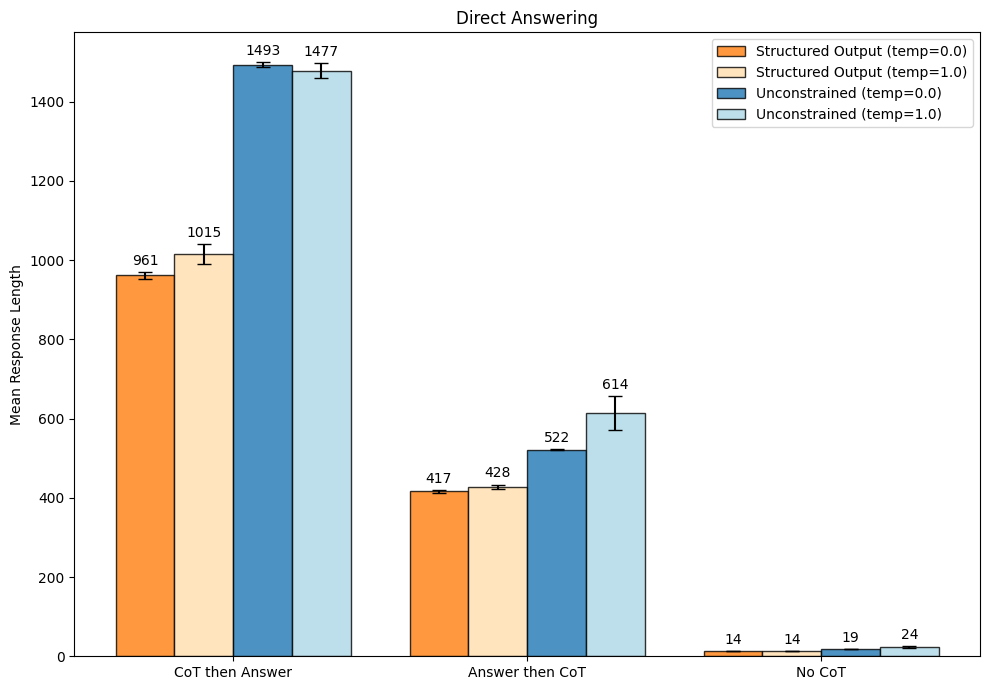

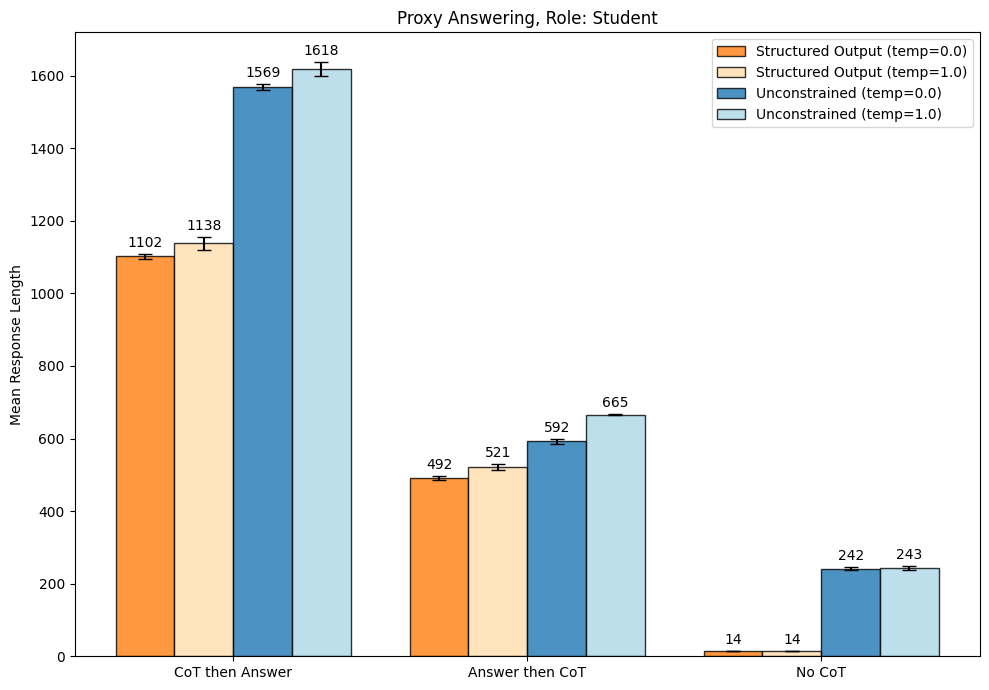

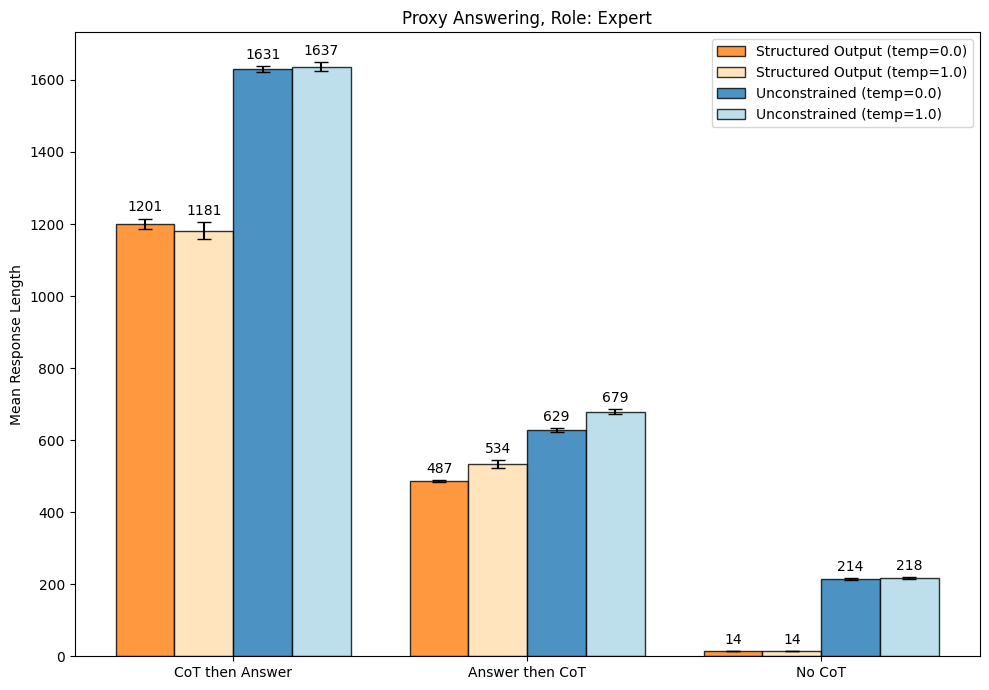

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to classify schema names as "Unconstrained" or "Structured Output"
def classify_schema(schema_name):
    if schema_name.lower() == 'no_schema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph with error bars
def plot_grouped_bars_combined(filtered_df, ans_jgt, role=None):
    # Ensure 'cot_type' ordering.
    cot_order = ['cot1', 'cot2', 'cot0']
    
    # Map 'schema_name' to either "Unconstrained" or "Structured Output"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Map temperature to readable labels
    temp_mapping = {'temp0': 'temp=0.0', 'temp1': 'temp=1.0'}
    filtered_df['temperature_label'] = filtered_df['temperature'].map(temp_mapping)
    
    # Combine 'schema_group' and 'temperature_label' to create 'group' variable
    filtered_df['group'] = filtered_df['schema_group'] + ' (' + filtered_df['temperature_label'] + ')'
    
    # Calculate the error bars using accuracy standard deviation
    filtered_df['yerr'] = filtered_df['response_length_stdev']
    
    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(
        index='cot_type',
        columns='group',
        values=['response_length_mean', 'yerr']
    ).reindex(cot_order)
    
    # Get the number of CoT types and groups
    num_cot_types = len(cot_order)
    groups = pivot_df.columns.levels[1]
    num_groups = len(groups)
    
    # Width settings for grouped bars
    total_width = 0.8
    bar_width = total_width / num_groups
    x = np.arange(num_cot_types)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define colors for each group
    colors = {
        'Unconstrained (temp=0.0)': 'tab:blue',
        'Unconstrained (temp=1.0)': 'lightblue',
        'Structured Output (temp=0.0)': 'tab:orange',
        'Structured Output (temp=1.0)': 'navajowhite'  # light orange
    }
    
    for i, group in enumerate(groups):
        means = pivot_df['response_length_mean'][group].values
        errors = pivot_df['yerr'][group].values
        positions = x + i * bar_width - total_width/2 + bar_width/2
        
        bars = ax.bar(
            positions,
            means,
            yerr=errors,
            width=bar_width,
            label=group,
            capsize=5,
            edgecolor='black',
            color=colors.get(group, 'gray'),
            alpha=0.8
        )
        
        # Add text annotations for each bar
        ax.bar_label(bars, labels=[f'{mean:.0f}' for mean in means], padding=3, fontsize=10)
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels([cot_labels[label] for label in cot_order])
    
    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Mean Response Length')

    # Get base title
    if ans_jgt == "ans":
        base_title = "Direct Answering"
    else:
        base_title = "Proxy Answering"

    if role:
        ax.set_title(f'{base_title}, Role: {role.capitalize()}')
    else:
        ax.set_title(f'{base_title}')
    
    ax.legend(title='')
    plt.tight_layout()
    plt.show()
    
# Function to extract CoT type from 'prompt_template'
def extract_cot_type(prompt_template):
    return prompt_template.split('_')[-1]

# Plotting for 'ans' (Direct Answering)
filtered_df_ans = df_metrics[
    df_metrics['prompt_template'].str.contains('ans') &
    (df_metrics['role'] == 'no_role')
].copy()

# Add CoT type as a separate column (cot0, cot1, cot2)
filtered_df_ans['cot_type'] = filtered_df_ans['prompt_template'].apply(extract_cot_type)

# Proceed to plot
plot_grouped_bars_combined(filtered_df_ans, ans_jgt='ans')

# Plotting for 'jgt' (Proxy Answering)
for role in ['student', 'expert']:
    filtered_df_jgt = df_metrics[
        df_metrics['prompt_template'].str.contains('jgt') &
        (df_metrics['role'] == role)
    ].copy()
    
    # Add CoT type as a separate column (cot0, cot1, cot2)
    filtered_df_jgt['cot_type'] = filtered_df_jgt['prompt_template'].apply(extract_cot_type)
    
    # Proceed to plot
    plot_grouped_bars_combined(filtered_df_jgt, ans_jgt='jgt', role=role)


# Plotting the response length standard deviation

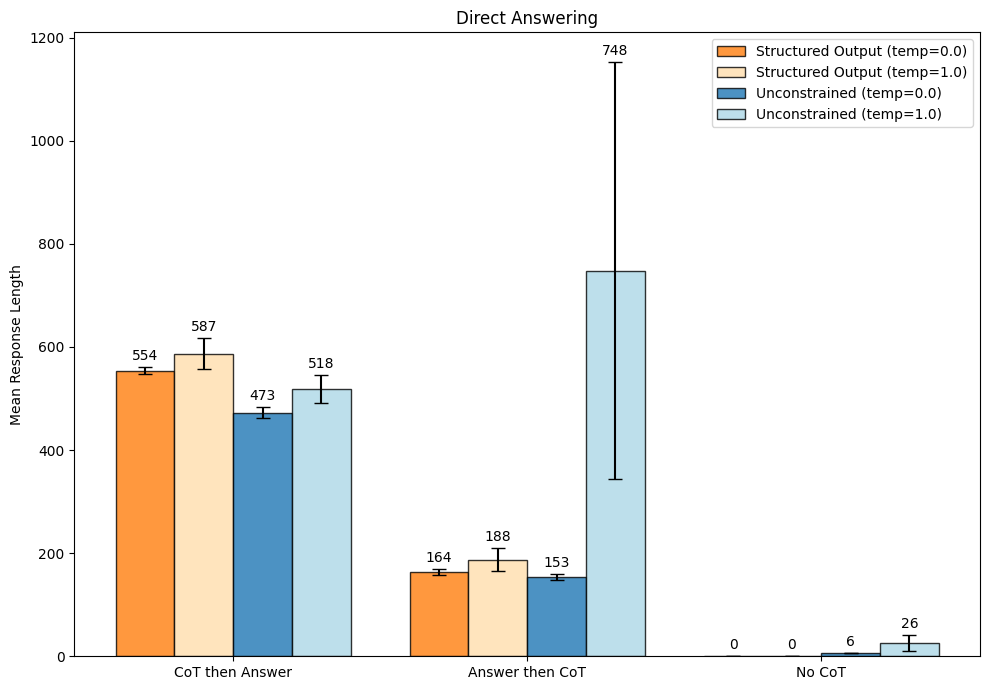

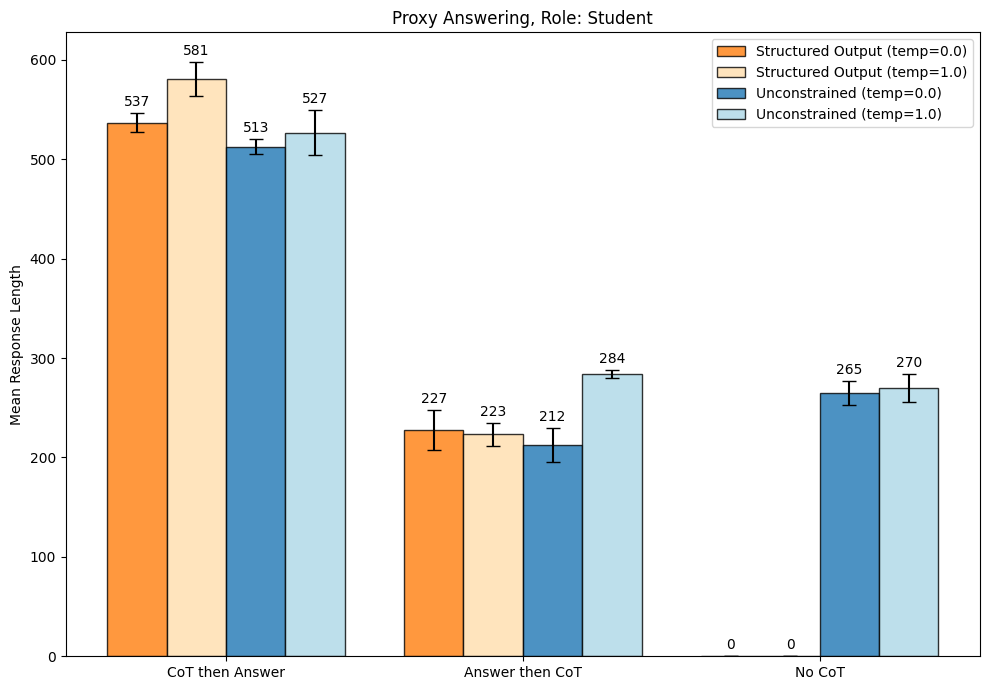

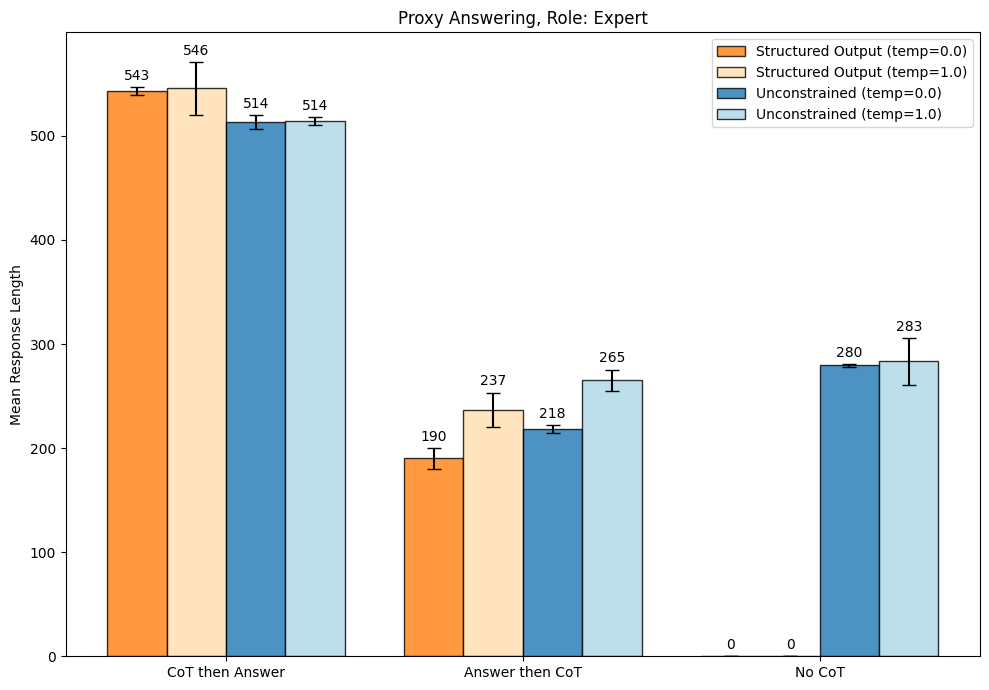

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to classify schema names as "Unconstrained" or "Structured Output"
def classify_schema(schema_name):
    if schema_name.lower() == 'no_schema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph with error bars
def plot_grouped_bars_combined(filtered_df, ans_jgt, role=None):
    # Ensure 'cot_type' ordering.
    cot_order = ['cot1', 'cot2', 'cot0']
    
    # Map 'schema_name' to either "Unconstrained" or "Structured Output"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Map temperature to readable labels
    temp_mapping = {'temp0': 'temp=0.0', 'temp1': 'temp=1.0'}
    filtered_df['temperature_label'] = filtered_df['temperature'].map(temp_mapping)
    
    # Combine 'schema_group' and 'temperature_label' to create 'group' variable
    filtered_df['group'] = filtered_df['schema_group'] + ' (' + filtered_df['temperature_label'] + ')'
    
    # Calculate the error bars using accuracy standard deviation
    filtered_df['yerr'] = filtered_df['response_length_stdev_stdev']
    
    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(
        index='cot_type',
        columns='group',
        values=['response_length_stdev_mean', 'yerr']
    ).reindex(cot_order)
    
    # Get the number of CoT types and groups
    num_cot_types = len(cot_order)
    groups = pivot_df.columns.levels[1]
    num_groups = len(groups)
    
    # Width settings for grouped bars
    total_width = 0.8
    bar_width = total_width / num_groups
    x = np.arange(num_cot_types)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define colors for each group
    colors = {
        'Unconstrained (temp=0.0)': 'tab:blue',
        'Unconstrained (temp=1.0)': 'lightblue',
        'Structured Output (temp=0.0)': 'tab:orange',
        'Structured Output (temp=1.0)': 'navajowhite'  # light orange
    }
    
    for i, group in enumerate(groups):
        means = pivot_df['response_length_stdev_mean'][group].values
        errors = pivot_df['yerr'][group].values
        positions = x + i * bar_width - total_width/2 + bar_width/2
        
        bars = ax.bar(
            positions,
            means,
            yerr=errors,
            width=bar_width,
            label=group,
            capsize=5,
            edgecolor='black',
            color=colors.get(group, 'gray'),
            alpha=0.8
        )
        
        # Add text annotations for each bar
        ax.bar_label(bars, labels=[f'{mean:.0f}' for mean in means], padding=3, fontsize=10)
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels([cot_labels[label] for label in cot_order])
    
    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Mean Response Length')

    # Get base title
    if ans_jgt == "ans":
        base_title = "Direct Answering"
    else:
        base_title = "Proxy Answering"

    if role:
        ax.set_title(f'{base_title}, Role: {role.capitalize()}')
    else:
        ax.set_title(f'{base_title}')
    
    ax.legend(title='')
    plt.tight_layout()
    plt.show()
    
# Function to extract CoT type from 'prompt_template'
def extract_cot_type(prompt_template):
    return prompt_template.split('_')[-1]

# Plotting for 'ans' (Direct Answering)
filtered_df_ans = df_metrics[
    df_metrics['prompt_template'].str.contains('ans') &
    (df_metrics['role'] == 'no_role')
].copy()

# Add CoT type as a separate column (cot0, cot1, cot2)
filtered_df_ans['cot_type'] = filtered_df_ans['prompt_template'].apply(extract_cot_type)

# Proceed to plot
plot_grouped_bars_combined(filtered_df_ans, ans_jgt='ans')

# Plotting for 'jgt' (Proxy Answering)
for role in ['student', 'expert']:
    filtered_df_jgt = df_metrics[
        df_metrics['prompt_template'].str.contains('jgt') &
        (df_metrics['role'] == role)
    ].copy()
    
    # Add CoT type as a separate column (cot0, cot1, cot2)
    filtered_df_jgt['cot_type'] = filtered_df_jgt['prompt_template'].apply(extract_cot_type)
    
    # Proceed to plot
    plot_grouped_bars_combined(filtered_df_jgt, ans_jgt='jgt', role=role)
